# Loading Data, Computing Metrics

Install Datasets library

In [1]:
!pip install datasets transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.6 MB/s eta 0:00:00


The STS Benchmark is a compilation of English language datasets utilized in the STS tasks of SemEval competitions that took place from 2012 to 2017. The dataset selection covers various text genres, including image captions, news headlines, and user forums. [ref](http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark)

Loading dataset and Metric

In [2]:
from datasets import load_dataset, load_metric
import numpy as np

In [11]:
task = "stsb"

In [12]:
dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

  0%|          | 0/3 [00:00<?, ?it/s]

View Dataset

In [13]:
print("Sample from the train, validation and test dataset:")
# Train Dataset
print("Train Sample",dataset["train"][0])
# Valid Dataset
print("Validation Sample",dataset["validation"][0])
# Test Dataset
# Label of test set is -1
print("Test Sample",dataset["test"][0])

print("\nSamples in dataset:")
# Train Dataset
print("Train Sample",len(dataset["train"]))
# Valid Dataset
print("Validation Sample",len(dataset["validation"]))
# Test Dataset
print("Test Sample",len(dataset["test"]))

Sample from the train, validation and test dataset:
Train Sample {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'label': 5.0, 'idx': 0}
Validation Sample {'sentence1': 'A man with a hard hat is dancing.', 'sentence2': 'A man wearing a hard hat is dancing.', 'label': 5.0, 'idx': 0}
Test Sample {'sentence1': 'A girl is styling her hair.', 'sentence2': 'A girl is brushing her hair.', 'label': -1.0, 'idx': 0}

Samples in dataset:
Train Sample 5749
Validation Sample 1500
Test Sample 1379


In [14]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


In [15]:
show_random_elements(dataset["train"])

,sentence1,sentence2,label,idx
0,China manufacturing index at 11-month low: HSBC,China manufacturing expands in September,1.00,5129
1,A man and a woman talk in a diner.,A man and a woman are riding on a bicycle.,1.20,187
2,"The Nasdaq composite index rose 13.70, or 0.8 per cent, to 1700.34.","The technology-laced Nasdaq Composite Index .IXIC gained 13.73 points, or 0.81 percent, to finish at 1,700.34.",3.75,2942
3,Journalists hail London Olympics opening,Israeli delegation marches in 2012 Olympics opener,1.00,3999
4,existing rods could produce 3-6 atomic bombs in 6-8 months.,experts stated that the rods could produce 3-6 atomic bombs in 6-8 months.,4.20,3533
5,Gunmen ambush police boat in Nigeria oil region,Sudanese police block protest at human rights commission,0.00,4804
6,US government shutdown begins - live updates,Government Shutdown Begins Over Health Care Feud,3.20,5066
7,"""We haven't decided whether to use an unbroken or dotted white line, but this is an experiment worth introducing,"" said David Richardson, the ICC's cricket manager.","""We haven't decided whether to use an unbroken or dotted white line,"" said Dave Richardson, the ICC's cricket manager.",4.00,2793
8,Egypt ministry again urges end to pro-Morsi protests,Egypt: Child killed in Cairo clashes after pro-Morsi protest,2.80,4952
9,A white dog walking in the snow.,A black and tan dog walking through the snow.,3.00,1669


Compute Pearson correlation coefficient and Spearman's rank correlation coefficient

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions
    return metric.compute(predictions=predictions, references=labels)

In [17]:
import numpy as np

# Predictions and labels between 0 and 5
fake_preds = np.random.randint(0, 6, size=(64,))
fake_labels = np.random.randint(0, 6, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'pearson': 0.1319426764779114, 'spearmanr': 0.11852671778303708}

# Experiments

## Early interaction using BERT tiny
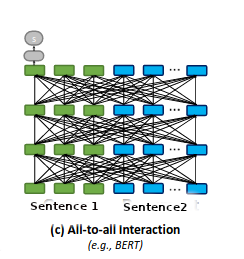

### Finetune a [BERT-tiny](https://huggingface.co/prajjwal1/bert-tiny) model on STSB train set and report scores on the validation set.

In [93]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, load_metric


In [94]:
model_checkpoint = "prajjwal1/bert-tiny"
batch_size = 16

In [95]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [96]:
def preprocess_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"],  padding = "longest", truncation=True,     return_tensors="pt" )

In [97]:
# TEST Pre Processing
preprocess_function(dataset['train'][:5])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  101,  1037,  4946,  2003,  2635,  2125,  1012,   102,  2019,  2250,
          4946,  2003,  2635,  2125,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1037,  2158,  2003,  2652,  1037,  2312,  8928,  1012,   102,
          1037,  2158,  2003,  2652,  1037,  8928,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1037,  2158,  2003,  9359, 14021,  5596,  2098,  8808,  2006,
          1037, 10733,  1012,   102,  1037,  2158,  2003,  9359, 29022,  8808,
          2006,  2019,  4895,  3597, 23461, 10733,  1012,   102],
        [  101,  2093,  2273,  2024,  2652,  7433,  1012,   102,  2048,  2273,
          2024,  2652,  7433,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1037,  2158,  2003,  2652,  1996, 10145,  1012,   102,  1037,
          2

In [98]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

In [99]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
num_labels  = 1
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [100]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=100,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    save_total_limit = 1,
)

In [101]:
def compute_metrics_for_training(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [102]:
! pip install optuna

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/build_env.py", line 14, in <module>
    from pip._vendor.certifi import where
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/certifi/__init__.py", line 1, in <module>
    from .core import contents, where
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/certifi/core.py", line 46, in <module>
    from

In [103]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [104]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_for_training
)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [105]:
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 

In [106]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2023-04-15 17:26:31,697] A new study created in memory with name: no-name-15f7df19-77f9-4e9a-aa1a-98d94a18d2f7
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificatio

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,2.836591,0.047345,0.054521
2,No log,2.220088,0.702022,0.701583
3,No log,2.113412,0.752314,0.737812


[I 2023-04-15 17:26:43,594] Trial 0 finished with value: 1.4901259076618252 and parameters: {'learning_rate': 6.093179517018185e-05, 'num_train_epochs': 3, 'seed': 18, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 1.4901259076618252.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,2.655802,0.644302,0.645908
2,4.395400,1.661623,0.704383,0.671919
3,1.939800,1.264434,0.705968,0.689210
4,1.939800,1.163018,0.714127,0.692772
5,1.315400,1.128341,0.723056,0.720409


[I 2023-04-15 17:27:22,450] Trial 1 finished with value: 1.4434649210177322 and parameters: {'learning_rate': 1.6680794861241852e-05, 'num_train_epochs': 5, 'seed': 37, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 1.4901259076618252.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,1.052635,0.746232,0.728997
2,2.066800,1.002722,0.768500,0.783726


[I 2023-04-15 17:27:36,355] Trial 2 finished with value: 1.5522258342282835 and parameters: {'learning_rate': 7.673230674357434e-05, 'num_train_epochs': 2, 'seed': 13, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 1.5522258342282835.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,7.288877,0.102736,0.071755


[I 2023-04-15 17:27:43,992] Trial 3 finished with value: 0.17449070068296232 and parameters: {'learning_rate': 2.3277537602167044e-06, 'num_train_epochs': 1, 'seed': 25, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 1.5522258342282835.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertF

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,5.512656,0.325975,0.284434


[I 2023-04-15 17:27:51,637] Trial 4 finished with value: 0.6104096502806979 and parameters: {'learning_rate': 5.5466602045776035e-06, 'num_train_epochs': 1, 'seed': 26, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 1.5522258342282835.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,6.846711,0.018598,-0.006303


[I 2023-04-15 17:27:55,384] Trial 5 pruned. 
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,7.797800,5.418797,0.310410,0.285610
2,6.298300,4.749358,0.401789,0.364548


[I 2023-04-15 17:28:53,269] Trial 6 finished with value: 0.76633713270201 and parameters: {'learning_rate': 1.2849588569732307e-06, 'num_train_epochs': 2, 'seed': 16, 'per_device_train_batch_size': 4}. Best is trial 2 with value: 1.5522258342282835.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSe

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,1.179600,1.033453,0.770033,0.798407
2,0.894100,0.902590,0.809451,0.821252
3,0.825600,0.887554,0.810573,0.820486
4,0.754500,0.868547,0.813114,0.821235


[I 2023-04-15 17:30:59,517] Trial 7 finished with value: 1.6343490263935347 and parameters: {'learning_rate': 4.049271571706195e-05, 'num_train_epochs': 4, 'seed': 34, 'per_device_train_batch_size': 4}. Best is trial 7 with value: 1.6343490263935347.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForS

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,5.990076,0.596584,0.580906


[I 2023-04-15 17:31:06,755] Trial 8 pruned. 
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,No log,8.370307,-0.327179,-0.330816


[I 2023-04-15 17:31:12,654] Trial 9 pruned. 


In [107]:
best_run

BestRun(run_id='7', objective=1.6343490263935347, hyperparameters={'learning_rate': 4.049271571706195e-05, 'num_train_epochs': 4, 'seed': 34, 'per_device_train_batch_size': 4}, run_summary=None)

In [108]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,1.179600,1.033453,0.770033,0.798407
2,0.894100,0.902590,0.809451,0.821252
3,0.825600,0.887554,0.810573,0.820486
4,0.754500,0.868547,0.813114,0.821235


TrainOutput(global_step=5752, training_loss=1.0795300607057872, metrics={'train_runtime': 119.1501, 'train_samples_per_second': 193.0, 'train_steps_per_second': 48.275, 'total_flos': 9603726724452.0, 'train_loss': 1.0795300607057872, 'epoch': 4.0})

## Dynamic Time Warping (DTW) without crossings using cosine simialrity/ euclidean distance

Given a pair of sentences, return optimal map between tokens of two sentences. Should handle degenerate solutions.

In [42]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

# Load the BERT-tiny model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = AutoModel.from_pretrained('prajjwal1/bert-tiny')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# Encode a sentence into a matrix of BERT-tiny embeddings
def encode_sentence(sentence):
    input_ids = tokenizer(sentence, return_tensors="pt" )
    with torch.no_grad():
        outputs = model(**input_ids)
        embeddings = outputs.last_hidden_state.squeeze(0)
    return embeddings.numpy()

# Compute the distance between two embeddings using cosine similarity
def cosine_similarity(x, y):
    sim = np.zeros((x.shape[0]-2, y.shape[0]-2))
    for i in range(sim.shape[0]):
      for j in range(sim.shape[1]):
        dt = np.dot(x[i+1], y[j+1]) 
        norm_x = np.linalg.norm(x[i+1])
        norm_y = np.linalg.norm(y[j+1])
        sim[i,j] = dt/(norm_x*norm_y)
    return sim

def compute_cost_matrix(sentence1, sentence2):
    embeddings1 = encode_sentence(sentence1)
    embeddings2 = encode_sentence(sentence2)
    sim_matrix = cosine_similarity(embeddings1, embeddings2)
    return sim_matrix

In [47]:
# Perform DTW with a non-crossing map that can handle degenerate solutions
def dtw(sentence1, sentence2):
    sim_matrix = compute_cost_matrix(sentence1, sentence2)
    n = sim_matrix.shape[0]
    m = sim_matrix.shape[1]
    DTW = np.zeros((n+1, m+1))
    alignment = np.zeros((n+1,m+1), dtype=int)

    for i in range(1, n+1):
        for j in range(1, m+1):
            s = sim_matrix[i-1,j-1]
            if ((DTW[i-1,j-1]+s > DTW[i,j-1]) and (DTW[i-1,j-1]+s > DTW[i-1,j])):
              DTW[i,j] = DTW[i-1,j-1] + s
              alignment[i,j] = j
            elif DTW[i-1,j] > DTW[i,j-1]:
              DTW[i,j] = DTW[i-1,j]
              alignment[i,j] = -1
            else:
              DTW[i,j] = DTW[i,j-1]
              alignment[i,j] = alignment[i,j-1]

    return DTW, alignment

In [54]:
s1 = "This is a test sentence"
s2 = "This sentence is a test"

DTW, align = dtw(s1, s2)
print("DTW Score:", DTW[-1, -1]) # Final Score 
print("Alignment Map:", align) # Alignment MAP

## The alignment map contains indices of most possible matching. For each row, i -> j
print("Alignment:", align[:,-1])

DTW Score: 4.336558163166046
Alignment Map: [[ 0  0  0  0  0  0]
 [ 0  1  1  1  1  1]
 [ 0 -1  2  3  3  3]
 [ 0 -1 -1  3  4  4]
 [ 0 -1 -1 -1  4  5]
 [ 0 -1  2 -1  4  5]]
Alignment: [0 1 3 4 5 5]


## Dynamic Time Warping (DTW) using Tanh Calibration

### Dynamic Time Warping (DTW) without crossings

**Obtain Optimal non-crossing mapping**

---
Let the longer sentence (the sentence with more tokens) be s1 and shorter be s2 and i be an index of token from sentence 1 and j be an index of token from sentence 2.
We can use DP to keep track of score for each mapping i to j. Here we impose that each j must be mapped to i i.e. the tokens of the shorter sentence must be matched to a token of the longer one.

 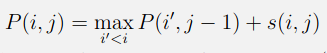

From the scores we can obtain the optimal mapping.


---


To allow some unmatched tokens on both sides, we can exclude the non negative similariy pairs during matching and let it not continute to the aggregate score.

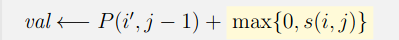


---

Any s(i, j) < 0 debars i from being a candidate for j. While cosine similarity can be positive or negative (in practice, negative cosine similarities are
somewhat rare), the fraction of cases where it is negative in an application may not be
consistent with the number of j we should aim to leave unassigned in the same application.
Also note that d(i, j) ≥ 0 always. If we instead use a notion of distance d(i, j), we need
to either switch the polarity of the dynamic programming recurrence, or use a decreasing
function of distance in the the recurrence. In either case, the check against 0 may become
trivial: no i may be rejected by j, or all is may be rejected. One solution (there may be
others) is to apply a smooth transformation of both s(i, j) and d(i, j) into a space that is
capable of being positive or negative with a distribution that optimizes for the end task,
say:

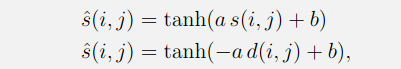

with additional parameters a, b to be trained.


Train a model to learn optimal a and b.

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm.notebook import tqdm

def tensor_cosine(x, y, a, b):
    sim = torch.zeros((x.shape[0]-2, y.shape[0]-2))
    for i in range(sim.shape[0]):
      for j in range(sim.shape[1]):
        sim[i,j] = torch.dot(x[i+1], y[j+1])/(torch.linalg.norm(x[i+1])*torch.linalg.norm(y[j+1]))
    return torch.nn.functional.tanh(a*sim + b)

In [56]:
# Non Crossing DTW for task three
def dtw_non_cross(embed1, embed2, a, b):
    s = tensor_cosine(embed1, embed2, a, b) 
    I = s.shape[0]
    J = s.shape[1]
    P = torch.zeros((I, J))

    for i in range(1, I):
        for j in range(1, J):
            if ((P[i-1,j-1]+s[i,j] > P[i,j-1]) and (P[i-1,j-1]+s[i,j] > P[i-1,j])):
              P[i,j] = P[i-1,j-1] + s[i,j]
            elif P[i-1,j] > P[i,j-1]:
              P[i,j] = P[i-1,j]
            else:
              P[i,j] = P[i,j-1]
    return P[I-1,J-1]/min(I,J)

In [68]:
# Dataset preprocess
# Training on Half Dataset to Avoid RAM Overflow
train_data_len = 2500

train_data = {
    "embed1": [encode_sentence(dataset["train"]["sentence1"][i]) for i in range(train_data_len)],
    "embed2": [encode_sentence(dataset["train"]["sentence2"][i]) for i in range(train_data_len)],
    "label": [dataset["train"]["label"][i] for i in range(train_data_len)]
} 

val_data = {
    "sentence1": dataset["validation"]["sentence1"],
    "sentence2": dataset["validation"]["sentence2"],
    "embed1": [encode_sentence(dataset["validation"]["sentence1"][i]) for i in range(len(dataset["validation"]))],
    "embed2": [encode_sentence(dataset["validation"]["sentence2"][i]) for i in range(len(dataset["validation"]))],
    "label": [dataset["validation"]["label"][i] for i in range(len(dataset["validation"]))]
}

In [59]:
a_non_cross = nn.Parameter(torch.tensor(1.0))
b_non_cross = nn.Parameter(torch.tensor(-0.5))

optimizer = optim.AdamW([a_non_cross, b_non_cross], lr=1e-3)

batch_size = 500
num_batches = (train_data_len + batch_size - 1) // batch_size
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    predicted_labels = []
    labels = []
    losses = []
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i+1)*batch_size, train_data_len)
        loss = 0
        pls = []
        ls = []

        for j in tqdm(range(batch_start, batch_end)):

            batch_embed1 = torch.tensor(train_data["embed1"][j])
            batch_embed2 = torch.tensor(train_data["embed2"][j])
            l = torch.tensor(train_data["label"][j]/2.5-1)
        
            pl = dtw_non_cross(batch_embed1, batch_embed2, a_non_cross, b_non_cross)
            loss = loss + (pl-l)**2
            pls.append(pl.item())
            ls.append(l.item())

        loss.backward()
        optimizer.step()

        predicted_labels.extend(pls)
        labels.extend(ls)
        losses.append((loss/batch_size).item())

    optimizer.zero_grad()
        
    metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
    print(f"Epoch {epoch}, Loss: {sum(losses)}, Metrics: {metrics}, a: {a_non_cross.item()}, b: {b_non_cross.item()}")
    

a_final = a_non_cross.item()
b_final = b_non_cross.item()

print(f"Final values for Non Crossing Mapping, of a: {a_final}, b: {b_final}")

Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 2.115538775920868, Metrics: {'pearson': 0.5575719667035878, 'spearmanr': 0.5416874330621368}, a: 0.99507737159729, b: -0.5048454403877258
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Loss: 2.0973595678806305, Metrics: {'pearson': 0.5585325074675384, 'spearmanr': 0.5424750901449329}, a: 0.9903260469436646, b: -0.5095118284225464
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2, Loss: 2.079867497086525, Metrics: {'pearson': 0.5594292787806653, 'spearmanr': 0.5432150225010897}, a: 0.9855821132659912, b: -0.51417076587677
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3, Loss: 2.062887579202652, Metrics: {'pearson': 0.5603265853437359, 'spearmanr': 0.5439242198456871}, a: 0.9808638095855713, b: -0.5188040733337402
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0464803129434586, Metrics: {'pearson': 0.5612115030162286, 'spearmanr': 0.5446882729360353}, a: 0.9761821627616882, b: -0.5234010815620422
Final values for Non Crossing Mapping, of a: 0.9761821627616882, b: -0.5234010815620422


In [60]:
a_non_cross, b_non_cross

(Parameter containing:
 tensor(0.9762, requires_grad=True),
 Parameter containing:
 tensor(-0.5234, requires_grad=True))

### Dynamic Time Warping (DTW) with crossings

Scoring cross mappings should be easy.


Train a model to learn optimal a and b.

In [62]:
def dtw_cross(embed1, embed2, a, b):
    s = tensor_cosine(embed1, embed2, a, b) 
    I = s.shape[0]
    J = s.shape[1]
    score = torch.tensor(0)

    for i in range(I):
        for j in range(J):
            if s[i,j] > 0:
                score = score + s[i,j]
    
    return (score/min(I,J))

In [63]:
a_cross = nn.Parameter(torch.tensor(1.0))
b_cross = nn.Parameter(torch.tensor(-0.5))

optimizer = optim.AdamW([a_cross, b_cross], lr=1e-3)

batch_size = 500
num_batches = (train_data_len + batch_size - 1) // batch_size
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    predicted_labels = []
    labels = []
    losses = []
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i+1)*batch_size, train_data_len)
        loss = 0
        pls = []
        ls = []

        for j in tqdm(range(batch_start, batch_end)):

            batch_embed1 = torch.tensor(train_data["embed1"][j])
            batch_embed2 = torch.tensor(train_data["embed2"][j])
            l = torch.tensor(train_data["label"][j]/2.5-1)
        
            pl = dtw_cross(batch_embed1, batch_embed2, a_cross, b_cross)
            loss = loss + (pl-l)**2
            pls.append(pl.item())
            ls.append(l.item())

        loss.backward()
        optimizer.step()

        predicted_labels.extend(pls)
        labels.extend(ls)
        losses.append((loss/batch_size).item())

    optimizer.zero_grad()
        
    metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
    print(f"Epoch {epoch}, Loss: {sum(losses)}, Metrics: {metrics}, a: {a_cross.item()}, b: {b_cross.item()}")
    

a_final = a_cross.item()
b_final = b_cross.item()

print(f"Final values For Crossing Map, of a: {a_final}, b: {b_final}")

Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 14.282109260559082, Metrics: {'pearson': 0.49608514057286296, 'spearmanr': 0.5115247869759615}, a: 0.995182454586029, b: -0.5047422647476196
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Loss: 13.1111159324646, Metrics: {'pearson': 0.5015617128026983, 'spearmanr': 0.516954846638129}, a: 0.9907674789428711, b: -0.5090774893760681
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2, Loss: 12.03724491596222, Metrics: {'pearson': 0.5068848429944726, 'spearmanr': 0.5221126116016631}, a: 0.9863687753677368, b: -0.513394296169281
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3, Loss: 11.035572052001953, Metrics: {'pearson': 0.5119143890312265, 'spearmanr': 0.5270714177409924}, a: 0.9820263385772705, b: -0.5176514387130737
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4, Loss: 10.109965682029724, Metrics: {'pearson': 0.5165883780561862, 'spearmanr': 0.5317467016927943}, a: 0.9777642488479614, b: -0.5218238234519958
Final values For Crossing Map, of a: 0.9777642488479614, b: -0.5218238234519958


In [64]:
a_cross, b_cross

(Parameter containing:
 tensor(0.9778, requires_grad=True),
 Parameter containing:
 tensor(-0.5218, requires_grad=True))

# Results

### Q3.1 Tanh Parameterised Validation Set - Non Crossing

In [82]:
# Checking Validation Dataset For Non Crossing
predicted_labels = []
labels = []
val_len = len(val_data["embed1"])
loss = 0

for i in tqdm(range(val_len)):
    emb1 = torch.tensor(val_data["embed1"][i])
    emb2 = torch.tensor(val_data["embed2"][i])
    l = torch.tensor(val_data["label"][i]/2.5-1)

    pl = dtw_non_cross(emb1, emb2, a_non_cross, b_non_cross)
    loss = loss + (pl-l)**2

    predicted_labels.append(pl.item())
    labels.append(l.item())
    
metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
print()
print(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a: {a_non_cross.item()}, b: {b_non_cross.item()}")

  0%|          | 0/1500 [00:00<?, ?it/s]


Loss: 0.3731934407552083, Metrics: {'pearson': 0.6014639887356266, 'spearmanr': 0.601540424026264}, a: 0.9761821627616882, b: -0.5234010815620422


In [83]:
# Save Outputs To File
with open("./q3_1_validation.txt", "w") as f:
    f.write(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a_non_cross: {a_non_cross.item()}, b_non_cross: {b_non_cross.item()} \n")
    f.write("Sentence1, Sentence2, Predicted Labels \n")
    for i in range(len(val_data["sentence1"])):
        f.write(f"{val_data['sentence1'][i]}, {val_data['sentence1'][i]}, {(predicted_labels[i]+1)*2.5} \n")

### Q3.2 Tanh Parameterised Validation Set - Crossing

In [84]:
# Checking Validation Dataset For Non Crossing
predicted_labels = []
labels = []
val_len = len(val_data["embed1"])
loss = 0

for i in tqdm(range(val_len)):
    emb1 = torch.tensor(val_data["embed1"][i])
    emb2 = torch.tensor(val_data["embed2"][i])
    l = torch.tensor(val_data["label"][i]/2.5-1)

    pl = dtw_cross(emb1, emb2, a_cross, b_cross)
    loss = loss + (pl-l)**2

    predicted_labels.append(pl.item())
    labels.append(l.item())
    
metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
print()
print(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a: {a_cross.item()}, b: {b_cross.item()}")

  0%|          | 0/1500 [00:00<?, ?it/s]


Loss: 2.137397786458333, Metrics: {'pearson': 0.537575188542166, 'spearmanr': 0.5932069535000509}, a: 0.9777642488479614, b: -0.5218238234519958


In [89]:
# Save Outputs To File
with open("./q3_2_validation.txt", "w") as f:
    f.write(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a_cross: {a_cross.item()}, b_cross: {b_cross.item()} \n")
    f.write("Sentence1, Sentence2, Predicted Labels \n")
    for i in range(len(val_data["sentence1"])):
        f.write(f"{val_data['sentence1'][i]}, {val_data['sentence1'][i]}, {(predicted_labels[i]+1)*2.5} \n")

In [75]:
test_data = {
    "sentence1": dataset["test"]["sentence1"],
    "sentence2": dataset["test"]["sentence2"],
    "embed1": [encode_sentence(dataset["test"]["sentence1"][i]) for i in range(len(dataset["test"]))],
    "embed2": [encode_sentence(dataset["test"]["sentence2"][i]) for i in range(len(dataset["test"]))],
}

### Saving the Outputs of Test Dataset

In [90]:
# Non Crossing Q3.1
predicted_labels = []
test_len = len(test_data["embed1"])

for i in tqdm(range(test_len)):
    emb1 = torch.tensor(test_data["embed1"][i])
    emb2 = torch.tensor(test_data["embed2"][i])
    pl = dtw_non_cross(emb1, emb2, a_non_cross, b_non_cross)
    predicted_labels.append(pl.item())

# Save Outputs To File
with open("./q3_1_test.txt", "w") as f:
    f.write(f"a_non_cross: {a_non_cross.item()}, b_non_cross: {b_non_cross.item()} \n")
    f.write("Sentence1, Sentence2, Predicted Labels \n")
    for i in range(len(test_data["sentence1"])):
        f.write(f"{test_data['sentence1'][i]}, {test_data['sentence1'][i]}, {(predicted_labels[i]+1)*2.5} \n")

  0%|          | 0/1379 [00:00<?, ?it/s]

In [92]:
# Crossing Q3.2
predicted_labels = []
test_len = len(test_data["embed1"])

for i in tqdm(range(test_len)):
    emb1 = torch.tensor(test_data["embed1"][i])
    emb2 = torch.tensor(test_data["embed2"][i])
    pl = dtw_cross(emb1, emb2, a_cross, b_cross)
    predicted_labels.append(pl.item())

# Save Outputs To File
with open("./q3_2_test.txt", "w") as f:
    f.write(f"a_cross: {a_cross.item()}, b_cross: {b_cross.item()} \n")
    f.write("Sentence1, Sentence2, Predicted Labels \n")
    for i in range(len(test_data["sentence1"])):
        f.write(f"{test_data['sentence1'][i]}, {test_data['sentence1'][i]}, {(predicted_labels[i]+1)*2.5} \n")

  0%|          | 0/1379 [00:00<?, ?it/s]